## Decision tree classifier for classifying trafficking vs non-trafficking

Need to install
- graphviz
- sklearn
- pydotplus
- mlxtend

Installs pydotplus for plotting of datatrees, since its not provided w default session. also installing graphviz

In [16]:
#!pip3 install pydotplus
#!pip3 install mlxtend

### Load requisite libraries

In [17]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import itertools
import matplotlib.gridspec as gridspec

%matplotlib inline
%reload_ext autoreload
%autoreload 2

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, plot_roc_curve

from mlxtend.data import iris_data
from sklearn.utils import resample

import os
import math
from math import floor, ceil

Stuff for plotting trees

In [18]:
from six import StringIO
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

plot data

In [19]:
def plotDT(dtree,featureNames = None,classNames=None):
    dot_data = StringIO()
    export_graphviz(dtree, 
                    out_file=dot_data,  
                    feature_names = featureNames,
                    class_names =  classNames,
                    filled=True, 
                    rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    l=Image(graph.create_png())
    return l

In [20]:
def TestAccuracy(clf,X_test,y_test, display=False):
    
    y_pred  = clf.predict( X_test.values)  
    results = ( y_test.values[:,0]==y_pred )

    if display:
        nEntries, dummy = X_test.shape
        for i in range(nEntries):
            print(X_test.iloc[i])
            print("Class=%s Prediction %s %s\n"%(y_test.values[i,0],y_pred[i],results[i]) )
        #print("prediction",results)

    # accuracy
    nTrue = np.sum( results )
    nTot = np.float( np.shape( results)[0] )
    accuracy = nTrue/nTot
    print("Overall accuracy ",accuracy)

def TestAccuracySingle(clf,X_test,Y_test,idx=0):
    
    print(X_test.iloc[idx])
    result = clf.predict( [X_test.values[idx,:]])
    print("prediction",result)
    #print(Y_test.iloc[idx])

In [21]:
#TestAccuracy(clf_entropy,X_test,Y_test,display=True)

### Example with PAS data 

In [22]:
import pandas as pd

In [23]:
os.getcwd()

'/Users/drkal/Desktop/professional/peter-lab/herg-project/machine-learning/my-work/dt/pas-all-features-trafficking-prediction'

In [24]:
#os.chdir('/Users/drkal/Desktop/professional/peter-lab/herg-project/machine-learning/my-work/dt/pas-md-trafficking-prediction')

### use "comment = '#'" for ignoring the commented out rows in pandas data frames

In [34]:
dataFile = "features-latest-sets1n2.txt"

df = pd.read_csv(dataFile, sep="\s+", comment='#')

#df = pd.read_csv("data/cereal.csv", skiprows = 1)
#df.columns = df.iloc[0]
#df=df.drop(df.index[0])
#print(df.head(5))
df.head()


,VARIANT,HELIX,TURNS,COILS,THREE-TEN,BETA,ISOLATED,RMSD,HBONDS,SASA,WATERS,FOLDX,CONSERVATION,HYDROPHOBICITY,CLASS,TRAFFICKING
0,a32t,21.1567,21.2058,14.4202,3.29401,39.6439,0.279349,1.23560,66.7186,6473.83,1479.93,3.763310,-0.549,-0.43,1,1
1,a57p,20.4290,21.8332,14.5935,3.53135,39.4690,0.144014,1.28151,66.0936,6477.76,1526.79,-0.764827,-0.312,-0.32,0,1
2,a78p,20.8206,21.3096,14.5379,3.19232,39.9190,0.220522,1.12505,65.8526,6479.56,1474.41,0.759351,1.487,-0.32,1,1
3,a85v,20.8686,21.4237,14.6775,3.12031,39.6774,0.232523,1.16450,65.4562,6544.62,1492.34,2.430410,-0.518,0.29,1,1
4,c108r,22.1452,21.1476,15.3975,2.75727,38.2283,0.324033,1.58552,62.7131,6753.12,1548.93,6.958320,0.745,-1.84,1,0


In [36]:
#df['decimal_place_2'] = df['decimal_place_2'].round(2)
df['HELIX'] = df['HELIX'].round(2)
df['TURNS'] = df['TURNS'].round(2)
df['COILS'] = df['COILS'].round(2)
df['THREE-TEN'] = df['THREE-TEN'].round(2)
df['BETA'] = df['BETA'].round(2)
df['RMSD'] = df['RMSD'].round(2)
df['HBONDS'] = df['HBONDS'].round()
df['SASA'] = df['SASA'].round()
df['WATERS'] = df['WATERS'].round()
df['FOLDX'] = df['FOLDX'].round(2)
df['CONSERVATION'] = df['CONSERVATION'].round(2)
df['HYDROPHOBICITY'] = df['HYDROPHOBICITY'].round(2)

df.head()


,VARIANT,HELIX,TURNS,COILS,THREE-TEN,BETA,ISOLATED,RMSD,HBONDS,SASA,WATERS,FOLDX,CONSERVATION,HYDROPHOBICITY,CLASS,TRAFFICKING
0,a32t,21.16,21.21,14.42,3.29,39.64,0.279349,1.24,67.0,6474.0,1480.0,3.76,-0.55,-0.43,1,1
1,a57p,20.43,21.83,14.59,3.53,39.47,0.144014,1.28,66.0,6478.0,1527.0,-0.76,-0.31,-0.32,0,1
2,a78p,20.82,21.31,14.54,3.19,39.92,0.220522,1.13,66.0,6480.0,1474.0,0.76,1.49,-0.32,1,1
3,a85v,20.87,21.42,14.68,3.12,39.68,0.232523,1.16,65.0,6545.0,1492.0,2.43,-0.52,0.29,1,1
4,c108r,22.15,21.15,15.40,2.76,38.23,0.324033,1.59,63.0,6753.0,1549.0,6.96,0.74,-1.84,1,0


In [37]:
#read a rmsf file to a pandas data frame
rmsfile = "/Users/drkal/Desktop/professional/peter-lab/herg-project/machine-learning/herg-features/rmsf/rmsf-matrix.txt"
dfrmsf = pd.read_csv(rmsfile, sep="\s+", comment='#')
dfrmsf.head()


,wt,l86p,t74p,v113g,l86r,v113e,v113p,a32t,a57p,a78p,...,v41f-c64g,v41f-q61g,v41i,v41m,v41w,v41y,v94g,y43c,y54h,y99s
0,2.10,2.95,2.96,2.25,2.09,2.21,2.82,2.01,1.92,2.43,...,2.51,2.83,2.01,2.43,2.86,2.32,1.80,2.57,2.76,2.58
1,1.12,1.96,1.90,1.26,1.14,1.21,1.89,0.95,1.04,1.04,...,1.09,1.75,1.02,1.24,1.47,0.93,0.94,1.42,1.49,1.10
2,0.47,1.28,1.30,0.51,0.50,0.49,1.34,0.49,0.49,0.48,...,0.53,1.01,0.49,0.55,0.61,0.52,0.46,0.57,0.73,0.55
3,0.47,1.06,1.05,0.51,0.50,0.48,1.16,0.51,0.48,0.48,...,0.53,0.89,0.48,0.57,0.75,0.51,0.47,0.67,0.68,0.57
4,0.52,0.96,0.90,0.54,0.52,0.52,1.09,0.51,0.53,0.53,...,0.51,0.74,0.52,0.58,0.57,0.59,0.50,0.61,0.64,0.53


In [38]:
#extract a subset of rows from rmsf file
dfrmsf_sub = dfrmsf.loc[89:94,] # actual residues in the sequence 115 to 120 
dfrmsf_sub2 = dfrmsf.loc[10:15,]# actual residues in the sequence 36 to 41
dfrmsf_sub3 = dfrmsf.loc[61:66,]# actual residues in the sequence 87 to 92
dfrmsf_sub4 = dfrmsf.loc[47:52,]# actual residues in the sequence 73 to 78

#calculate the mean of the rows 89 to 94 for each variant
dfrmsf_sub_mean = dfrmsf_sub.mean().round(2)
dfrmsf_sub2_mean = dfrmsf_sub2.mean().round(2)
dfrmsf_sub3_mean = dfrmsf_sub3.mean().round(2)
dfrmsf_sub4_mean = dfrmsf_sub4.mean().round(2)

#dfrmsf_sub_mean

In [39]:
dfrmsf_sub_mean.shape

(78,)

In [43]:
#save the mean of rows 89 to 94 to a file
dfrmsf_sub_mean.to_csv('/Users/drkal/Desktop/professional/peter-lab/herg-project/machine-learning/herg-features/rmsf/rmsf_sub.txt', sep='\t', header=["RMSF115TO120"])
dfrmsf_sub2_mean.to_csv('/Users/drkal/Desktop/professional/peter-lab/herg-project/machine-learning/herg-features/rmsf/rmsf_sub2.txt', sep='\t', header=["RMSF36TO41"])
dfrmsf_sub3_mean.to_csv('/Users/drkal/Desktop/professional/peter-lab/herg-project/machine-learning/herg-features/rmsf/rmsf_sub3.txt', sep='\t', header=["RMSF87TO92"])
dfrmsf_sub4_mean.to_csv('/Users/drkal/Desktop/professional/peter-lab/herg-project/machine-learning/herg-features/rmsf/rmsf_sub4.txt', sep='\t', header=["RMSF73TO78"])


In [44]:
dfrmsf_sub_mean.columns=['RMSF115TO120']

In [45]:
df2 = pd.read_csv('/Users/drkal/Desktop/professional/peter-lab/herg-project/machine-learning/herg-features/rmsf/rmsf_sub.txt', sep='\t')

In [46]:
df2

,Unnamed: 0,RMSF115TO120
0,wt,1.51
1,l86p,3.04
2,t74p,2.99
3,v113g,1.76
4,l86r,1.67
...,...,...
73,v41y,1.57
74,v94g,1.63
75,y43c,1.59
76,y54h,1.88


In [47]:
features=["HELIX","TURNS","COILS","THREE-TEN","BETA","RMSD","HBONDS","SASA","WATERS","FOLDX","CONSERVATION","HYDROPHOBICITY"]
#features1=["HBONDS","WATERS","FOLDX", "TURNS","CONSERVATION"]

output = ["TRAFFICKING"]

In [48]:
#X = df[features1]
X = df[features]
Y = df[output]
#X.head()
#Y.head()

In [49]:
X_train, X_test, Y_train, Y_test =\
  train_test_split( X, Y, train_size=0.7, test_size=0.3, random_state=50)

<font color=red> Data looks very unbalanced</font>

In [50]:
### upsample the minority class, which is benign (class = 0)

In [51]:
# concatenate our traning data back together
#C = pd.concat([X_train, Y_train], axis=1)

In [52]:
# seperate minority and majority classes
#group = C.groupby('CLASS')
#benign=list(group)[0][1]
#pathogenic=list(group)[1][1]

In [53]:
#upsample minority
#benign_upsampled = resample(benign,
#                            replace=True, #sample with replacement
#                            n_samples=len(pathogenic), #match number in majority class
#                            random_state=100 #reproduce results
#                           )

In [54]:
#combine majority and upsampled minority
#upsampled = pd.concat([pathogenic, benign_upsampled])

Using class_weight="balanced" to reweight classes based on class frequency

In [55]:
#initializing the classifier and fitting it
clf_entropy = DecisionTreeClassifier(
  criterion = "entropy",
  #class_weight="balanced",
  random_state=50, #set random number seed  
  max_depth=None,
    max_features=4,
    min_samples_leaf=1) #min of samples needed at a node for it to split further

In [56]:
# train the classifier with resampled data
#X_train=pd.DataFrame(upsampled, columns=["RMSD", "HBONDS", "WATERS"])
#X_train=pd.DataFrame(upsampled, columns=["RMSD"])
#Y_train=pd.DataFrame(upsampled, columns=["CLASS"])

model=clf_entropy.fit(X_train, Y_train)

In [57]:
# print training accuracy
print("Training sample accuracy")
TestAccuracy(clf_entropy,X_train,Y_train)

Training sample accuracy
Overall accuracy  1.0


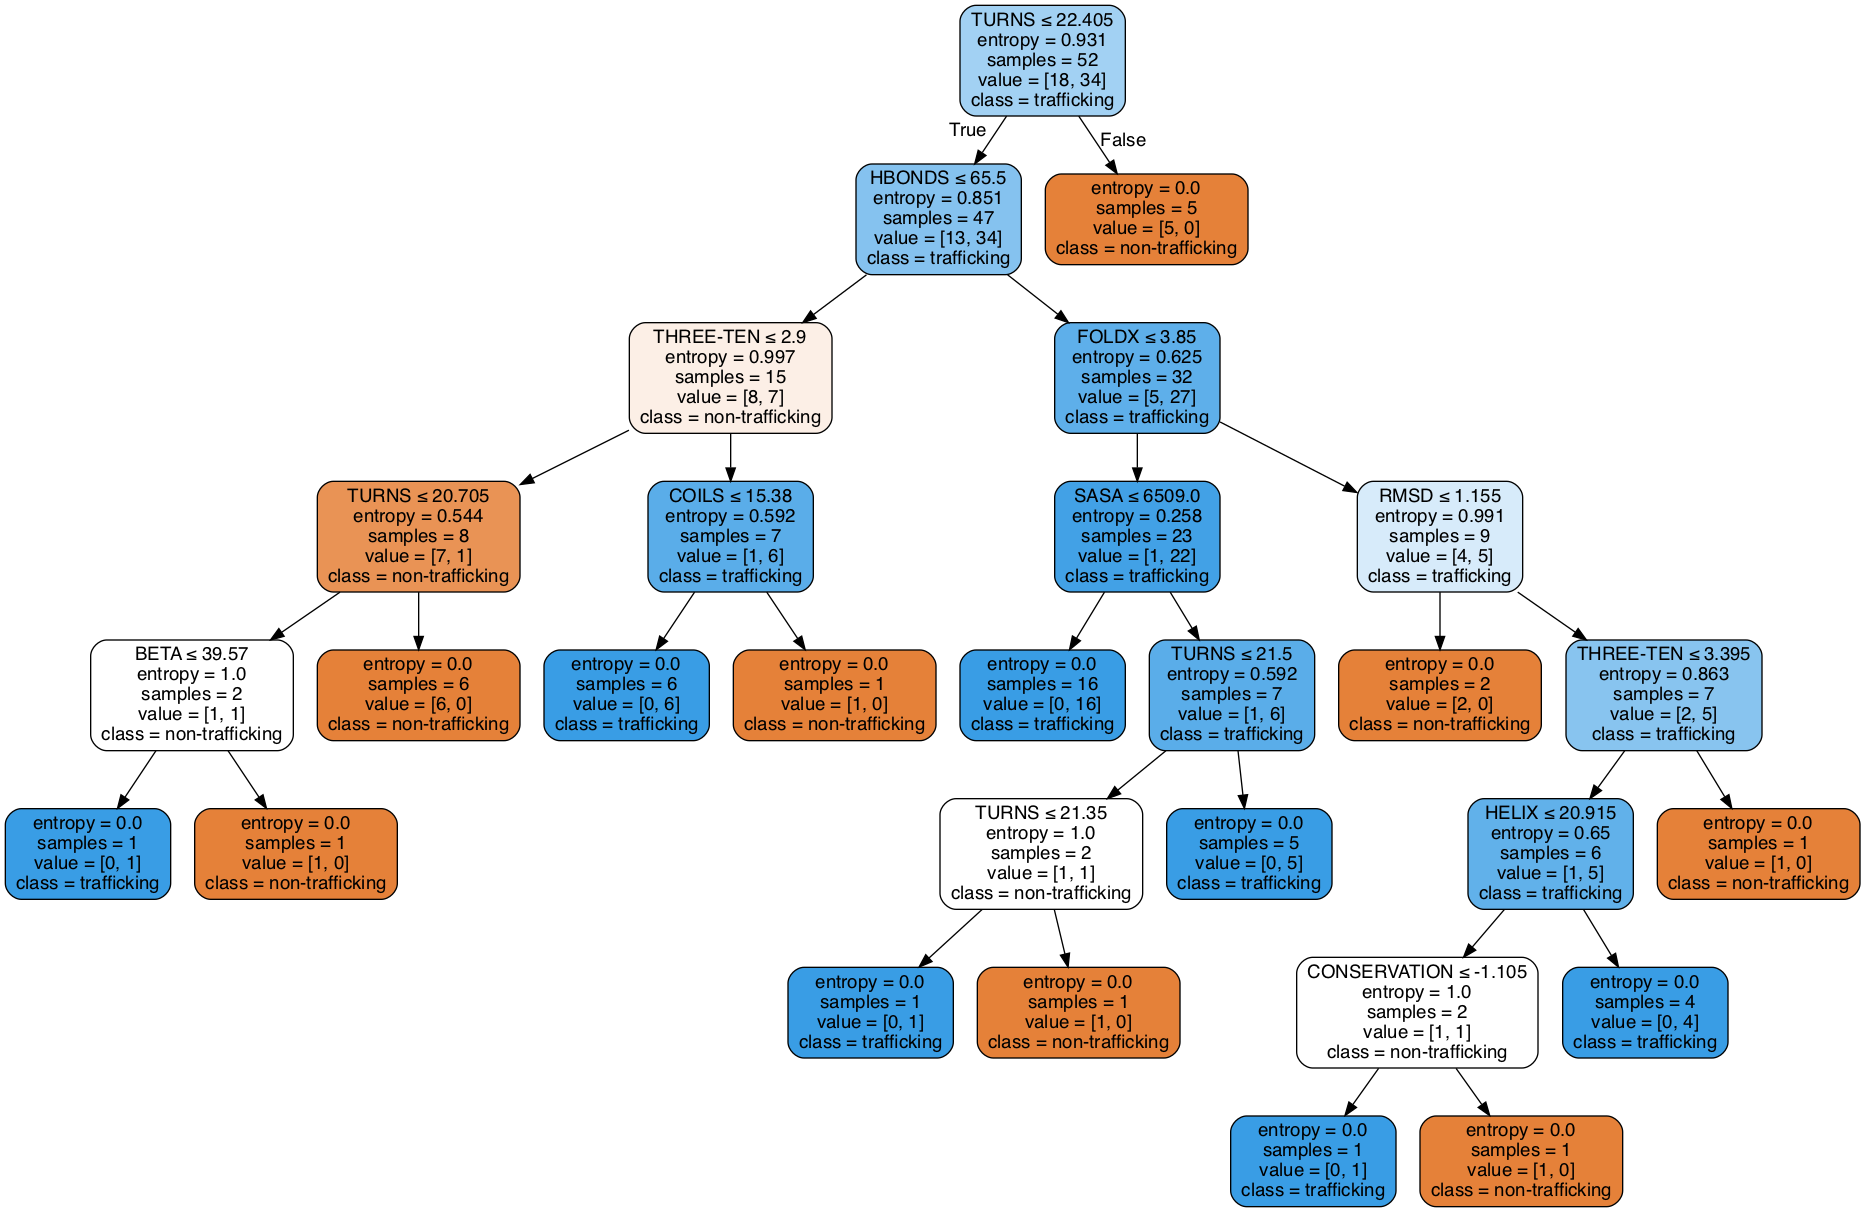

In [58]:
#classNames=np.array(['0', '1']) # need to verify, but I think this is correct
#classNames=np.array(['benign', 'pathogenic']) # need to verify, but I think this is correct
classNames=np.array(['non-trafficking', 'trafficking']) # need to verify, but I think this is correct
plotDT(clf_entropy,featureNames=features, classNames=classNames)

In [59]:
plt.savefig('dt_tree_allfeatures.pdf')

<Figure size 432x288 with 0 Axes>

In [60]:
#TestAccuracy(clf_entropy,X_test,Y_test, display=True)
print('Test Accuracy')
TestAccuracy(clf_entropy,X_test,Y_test)

Test Accuracy
Overall accuracy  0.7391304347826086


In [61]:
y_predict = clf_entropy.predict(X_test.values)

#model = lr.fit(X,y)
#probas_ = model.predict_log_proba(X)
#y_predict_proba = model.predict_proba(X_test)

In [62]:
### Print overall classification metrics
print(classification_report(Y_test, y_predict, target_names=classNames))
plt.savefig('report.png')

                 precision    recall  f1-score   support

non-trafficking       0.88      0.58      0.70        12
    trafficking       0.67      0.91      0.77        11

       accuracy                           0.74        23
      macro avg       0.77      0.75      0.73        23
   weighted avg       0.78      0.74      0.73        23



<Figure size 432x288 with 0 Axes>

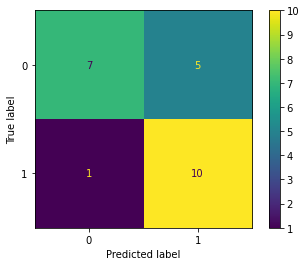

In [63]:
#print(confusion_matrix(Y_test, y_predict))
plot_confusion_matrix(clf_entropy, X_test, Y_test)
plt.savefig('dt_cm_allfeatures.pdf')

In [64]:
#y_predict = clf_entropy.predict(X_test)

#Y_test=np.array(Y_test)
#Y_test2=Y_test.reshape(23,)

#new_ypredict = [int(y) for y in y_predict]
#new_Y_test = [int(f) for f in Y_test2]

#fpr, tpr, thresholds = metrics.roc_curve(new_Y_test, new_ypredict, pos_label=1)

#print ("FPR", fpr*100)
#print ("TPR", tpr*100)
#print ("thresholds", thresholds)

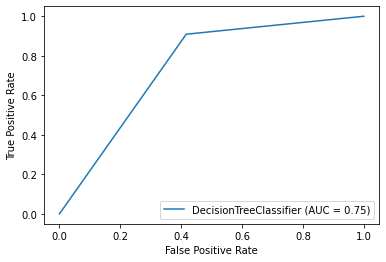

In [65]:
# plot roc curve
#metrics.roc_curve(clf_entropy, X_test, Y_test)
metrics.plot_roc_curve(clf_entropy, X_test, Y_test)
plt.savefig('dt_roc_allfeatures.pdf')

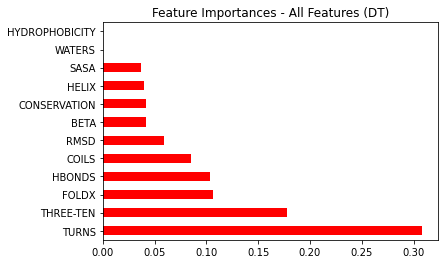

In [73]:
# print feature importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', color="red").grid(False)
plt.title('Feature Importances - All Features (DT)')
#plt.legend(bbox_to_anchor=(1,1))
plt.savefig('dt_fi_allfeatures.png', bbox_inches='tight')

In [74]:
# Import model and visualizer
#from yellowbrick.model_selection import FeatureImportances
#from sklearn.ensemble import RandomForestClassifier

# Instantiate model and visualizer
#model = RandomForestClassifier(n_estimators=10, random_state=1)
#visualizer = FeatureImportances(model)

# Fit and display visualizer
#visualizer.fit(X, Y)
#visualizer.show();
#plt.savefig('dt_fi_allfeatures2.png', bbox_inches='tight')

### predicting probabilities rather than hard predicitons

### generate data for ROC curve

In [75]:
HEX = df[['HELIX']]
B = df[["BETA"]]
T = df[["TURNS"]]
C = df[["COILS"]]
TT = df[["THREE-TEN"]]
R = df[["RMSD"]]
W = df[["WATERS"]]
H = df[["HBONDS"]]
S = df[["SASA"]]
F=df[['FOLDX']]
CO=df[["CONSERVATION"]]
HY=df[["HYDROPHOBICITY"]]

Y = df["TRAFFICKING"]
#X = df[features]

#extracting metrics for whole model
y_predict = clf_entropy.fit(X_train, Y_train).predict_proba(X_test)
#y_predict = clf_entropy.fit(X_train, Y_train).decisions(X_test)
fpr, tpr, thr = metrics.roc_curve(Y_test, y_predict[:,1], drop_intermediate=False)
auc = metrics.auc(fpr, tpr)


#redifined the classifier for one feature
clf2_dt = DecisionTreeClassifier(criterion = "entropy",random_state=50,max_depth=None, min_samples_leaf=1)

#helicity
#split
HEX_train, HEX_test, HEY_train, HEY_test = train_test_split(HEX, Y, train_size=0.7, test_size=0.3, random_state=50)
#train
#modelHE=clf2_dt.fit(HEX_train, HEY_train.values.ravel())
#train
#HEY_predict = clf2_dt.predict(HEX_test.values)
HEY_predict = clf2_dt.fit(HEX_train, HEY_train.values.ravel()).predict_proba(HEX_test.values)
f_helix, t_helix, th_helix = metrics.roc_curve(HEY_test, HEY_predict[:,1], pos_label=1, drop_intermediate=False)
helix_auc = metrics.auc(f_helix, t_helix)

#beta
bx_train, bx_test, by_train, by_test = train_test_split(B, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelB=clf2_dt.fit(bx_train, by_train.values.ravel())
#by_predict = clf2_dt.predict(bx_test.values)
by_predict = clf2_dt.fit(bx_train, by_train).predict_proba(bx_test)
f_beta, t_beta, th_beta = metrics.roc_curve(by_test, by_predict[:,1], pos_label=1, drop_intermediate=False)
beta_auc = metrics.auc(f_beta, t_beta)

#coil
cx_train, cx_test, cy_train, cy_test = train_test_split(C, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelC=clf2_dt.fit(cx_train, cy_train.values.ravel())
#cy_predict = clf2_dt.predict(cx_test.values)
cy_predict = clf2_dt.fit(cx_train, cy_train).predict_proba(cx_test)
f_coil, t_coil, th_coil = metrics.roc_curve(cy_test, cy_predict[:,1], pos_label=1, drop_intermediate=False)
coil_auc = metrics.auc(f_coil, t_coil)

#3-10
ttx_train, ttx_test, tty_train, tty_test = train_test_split(TT, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelTT=clf2_dt.fit(ttx_train, tty_train.values.ravel())
#tty_predict = clf2_dt.predict(ttx_test.values)
tty_predict = clf2_dt.fit(ttx_train, tty_train).predict_proba(ttx_test)
f_tten, t_tten, th_tten = metrics.roc_curve(tty_test, tty_predict[:,1], pos_label=1, drop_intermediate=False)
tten_auc = metrics.auc(f_tten, t_tten)

#rmsd
#extract metrics for rmsd. f_rmsd = false positive rate, t_rmsd=true positive rate, th_rmsd=threshold values
rx_train, rx_test, ry_train, ry_test = train_test_split(R, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelR=clf2_dt.fit(rx_train, ry_train.values.ravel())
#ry_predict = clf2_dt.predict(rx_test.values)
ry_predict = clf2_dt.fit(rx_train, ry_train).predict_proba(rx_test)
f_rmsd, t_rmsd, th_rmsd = metrics.roc_curve(ry_test, ry_predict[:,1], pos_label=1, drop_intermediate=False)
rmsd_auc = metrics.auc(f_rmsd, t_rmsd)

#extract metrics for sasa
sx_train, sx_test, sy_train, sy_test = train_test_split(S, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelS=clf2_dt.fit(sx_train, sy_train.values.ravel())
#sy_predict = clf2_dt.predict(sx_test.values)
sy_predict = clf2_dt.fit(sx_train, sy_train).predict_proba(sx_test)
f_sasa, t_sasa, th_sasa = metrics.roc_curve(sy_test, sy_predict[:,1], pos_label=1, drop_intermediate=False)
sasa_auc = metrics.auc(f_sasa, t_sasa)

#hbonds
#extract metrics for hbonds
hx_train, hx_test, hy_train, hy_test = train_test_split(H, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelH=clf2_dt.fit(hx_train, hy_train.values.ravel())
#hy_predict = clf2_dt.predict(hx_test.values)
hy_predict = clf2_dt.fit(hx_train, hy_train).predict_proba(hx_test)
f_hbonds, t_hbonds, th_hbonds = metrics.roc_curve(hy_test, hy_predict[:,1], pos_label=1, drop_intermediate=False)
hbonds_auc = metrics.auc(f_hbonds, t_hbonds)

#water
#extract metrics for water
wx_train, wx_test, wy_train, wy_test = train_test_split(W, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelW=clf2_dt.fit(wx_train, wy_train.values.ravel())
#wy_predict = clf2_dt.predict(wx_test.values)
wy_predict = clf2_dt.fit(wx_train, wy_train).predict_proba(wx_test)
f_water, t_water, th_water = metrics.roc_curve(wy_test, wy_predict[:,1], pos_label=1)
water_auc = metrics.auc(f_water, t_water)

#turns
tx_train, tx_test, ty_train, ty_test = train_test_split(T, Y, train_size=0.7, test_size=0.3, random_state=50)
modelT=clf2_dt.fit(tx_train, ty_train.values.ravel())
#ty_predict = clf2_dt.predict(tx_test.values)
ty_predict = clf2_dt.fit(tx_train, ty_train).predict_proba(tx_test)
f_turns, t_turns, th_turns = metrics.roc_curve(ty_test, ty_predict[:,1], pos_label=1, drop_intermediate=False)
turns_auc = metrics.auc(f_turns, t_turns)



#foldx
fx_train, fx_test, fy_train, fy_test = train_test_split(F, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelF=clf2_dt.fit(fx_train, fy_train.values.ravel())
#fy_predict = clf2_dt.predict(fx_test.values)
fy_predict = clf2_dt.fit(fx_train, fy_train).predict_proba(fx_test)
f_foldx, t_foldx, th_foldx = metrics.roc_curve(fy_test, fy_predict[:,1], pos_label=1, drop_intermediate=False)
foldx_auc = metrics.auc(f_foldx, t_foldx)

#conservation
cox_train, cox_test, coy_train, coy_test = train_test_split(CO, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelCO=clf2_dt.fit(cox_train, coy_train.values.ravel())
#coy_predict = clf2_dt.predict(cox_test)
coy_score = clf2_dt.fit(cox_train, coy_train).predict_proba(cox_test)
f_cons, t_cons, th_cons = metrics.roc_curve(coy_test, coy_score[:,1], pos_label=1, drop_intermediate=False)
cons_auc = metrics.auc(f_cons, t_cons)

#hydrophobicity
hyx_train, hyx_test, hyy_train, hyy_test = train_test_split(HY, Y, train_size=0.7, test_size=0.3, random_state=50)
#modelHY=clf2_dt.fit(hyx_train, hyy_train.values.ravel())
#hyy_predict = clf2_dt.predict(hyx_test.values)
#hyy_predict = clf2_dt.decision_function(hyx_test.values)
hyy_predict = clf2_dt.fit(hyx_train, hyy_train).predict_proba(hyx_test)
#f_hydr, t_hydr, th_hydr = metrics.roc_curve(hyy_test, hyy_predict)
f_hydr, t_hydr, th_hydr = metrics.roc_curve(hyy_test, hyy_predict[:,1], drop_intermediate=False)
hydr_auc = metrics.auc(f_hydr, t_hydr)


### Plot ROC

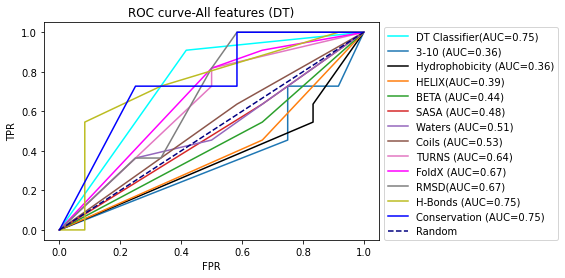

In [76]:
#plot the roc curves of rmsd, waters and hbonds. auc is area under the curve
#plot_roc_curve(clf_entropy, X_test, Y_test)
plt.plot (fpr, tpr, color='cyan', label="DT Classifier(AUC=%0.2f)"% auc)
plt.plot (f_tten, t_tten, label="3-10 (AUC=%0.2f)"% tten_auc)
plt.plot (f_hydr, t_hydr, color='black', label="Hydrophobicity (AUC=%0.2f)"% hydr_auc)
plt.plot(f_helix, t_helix, label="HELIX(AUC=%0.2f)"% helix_auc)
plt.plot (f_beta, t_beta, label="BETA (AUC=%0.2f)"% beta_auc)
plt.plot (f_sasa, t_sasa, label="SASA (AUC=%0.2f)"% sasa_auc)
plt.plot (f_water, t_water, label="Waters (AUC=%0.2f)"% water_auc)
plt.plot (f_coil, t_coil, label="Coils (AUC=%0.2f)"% coil_auc)
plt.plot (f_turns, t_turns, label="TURNS (AUC=%0.2f)"% turns_auc)
plt.plot (f_foldx, t_foldx, color='magenta', label="FoldX (AUC=%0.2f)"% foldx_auc)
plt.plot(f_rmsd, t_rmsd, label="RMSD(AUC=%0.2f)"% rmsd_auc)
plt.plot (f_hbonds, t_hbonds, label="H-Bonds (AUC=%0.2f)"% hbonds_auc)
plt.plot (f_cons, t_cons, color='blue', label="Conservation (AUC=%0.2f)"% cons_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random')
plt.grid(False)
plt.title('ROC curve-All features (DT)')
plt.xlabel("FPR")
plt.ylabel("TPR")
#plt.legend(loc="lower right")

plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig('dt_roc_allfeatures.pdf', bbox_inches='tight')


###plot just the model

In [77]:
#plt.plot (fpr, tpr, color='black', label="DT(AUC=%0.2f)"% auc)
#plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random')
#plt.title('ROC curve-All features (DT)')
#plt.xlabel("FPR")
#plt.ylabel("TPR")
#plt.legend(loc="lower right")

##plt.legend(bbox_to_anchor=(1,0.9), loc='upper left')
#plt.savefig('dt_roc_allfeatures_justmodel.pdf', bbox_inches='tight')

In [78]:
#import math
#from math import floor, ceil

#print ("FPR-RMSD", f_rmsd)
#print ("TPR-RMSD", t_rmsd)
#print ("thresholds-RMSD", th_rmsd)

#print ("FPR-WATERS", f_water)
#print ("TPR-WATERS", t_water)
#print ("thresholds-WATERS", th_water)

#print ("FPR-HBONDS", f_hbonds)
#print ("TPR-HBONDS", t_hbonds)
#print ("thresholds-HBONDS", th_hbonds)


In [80]:
bio_fpr = np.array([0. , 0.5, 1. ])
bio_tpr = np.array([0., 1., 1.])
bio_auc = 0.75

md_fpr = np.array([0.        , 0.41666667, 1.        ])
md_tpr = np.array([0.        , 0.72727273, 1.        ])
md_auc = 0.6553030303030303

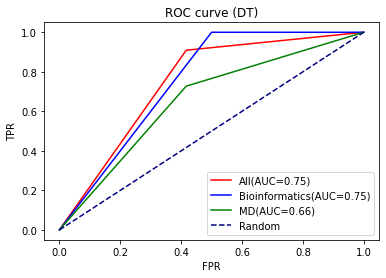

In [82]:
#plot_roc_curve(clf_rf, X_test, Y_test, color='red', label="All(AUC=%0.2f)")
plt.plot (fpr, tpr, color='red', label="All(AUC=%0.2f)"%auc)
plt.plot (bio_fpr, bio_tpr, color='blue', label="Bioinformatics(AUC=%0.2f)"%bio_auc)
plt.plot (md_fpr, md_tpr, color='green', label="MD(AUC=%0.2f)"%md_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random')

plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC curve (DT)')

plt.savefig('dt_roc_all_models.pdf', bbox_inches='tight')